# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage
from skimage import util


# Model Implementation

\begin{equation*}
    \frac{\partial{a}}{\partial{t}} = 16 - a b + r s \nabla^2 a
\end{equation*}

\begin{equation*}
    \frac{\partial{b}}{\partial{t}} = a b - b - 12 + s \nabla^2 b
\end{equation*}

$a, b = $ reagents concentrations

$r$ = Diffusion 'ratio'

$s$ = Diffusion 'scale'

$\nabla_2 n = $ (Laplacian) concentration of reagent $n$ at a location with respect to nearby concentration

This model ([Malheiros, Fensterseifer and Walter (2020)](https://mgmalheiros.github.io/research/leopard/)) defines the behavior of two reagents $a$ and $b$, where the first term of each equation describes the reaction process while the term with Laplacian operator $\nabla^2$ describes the diffusion process.

The differential equations solution is implemented using Euler Method.

\begin{equation*}
    y_{n+1} = y_n + hf(y_n, t_n)
\end{equation*}

In [2]:
#   model(a, b, kernel_a, kernel_b, lap_a, lap_b, diff_a, diff_b, delta_t, inf_a, inf_b, sup_a, sup_b, wrap)
def model(rd_a, rd_b, k_a, k_b, lap_a, lap_b, diff_a, diff_b, dt, inf_a, inf_b, sup_a, sup_b, wrap):

    if wrap:
        ndimage.convolve(rd_a, k_a, output=lap_a, mode='wrap')
        ndimage.convolve(rd_b, k_b, output=lap_b, mode='wrap')
    else:
        ndimage.convolve(rd_a, k_a, output=lap_a, mode='reflect')
        ndimage.convolve(rd_b, k_b, output=lap_b, mode='reflect')

    na = rd_a + (16 - rd_a * rd_b + diff_a * lap_a) * dt
    nb = rd_b + (rd_a * rd_b - rd_b - 12 + diff_b * lap_b) * dt

    global a, b
    np.clip(na, inf_a, sup_a, out=a)
    np.clip(nb, inf_b, sup_b, out=b)


## Other solutions

The solution for the differential equations may be obtained using other methods, such as 2º Order Runge-Kutta

\begin{equation*}
\\ k_1 = hf(y_n, t_n)
\end{equation*}

\begin{equation*}
\\ k_2 = hf(y_n + k_1, t_n + h)
\end{equation*}

\begin{equation*}
\\ y_{n+1} = y_n + \frac{(k_1 + k_2)}{2}
\end{equation*}

or 4º Order Runge-Kutta

\begin{equation*}
\\ k_1 = hf(y_n, t_n)
\end{equation*}

\begin{equation*}
\\ k_2 = hf(y_n + k_1 / 2, t_n + h / 2)
\end{equation*}

\begin{equation*}
\\ k_3 = hf(y_n + k_2 / 2, t_n + h / 2)
\end{equation*}

\begin{equation*}
\\ k_4 = hf(y_n + k_3, t_n + h)
\end{equation*}

\begin{equation*}
\\ y_{n+1} = y_n + \frac{(k_1 + k_2 + k_3 + k_4)}{6}
\end{equation*}

In [3]:
def RK2(A, B, ka, kb, la, lb, da, db, dt, inf_a, inf_b, sup_a, sup_b, wrap):
    if wrap:
        ndimage.convolve(A, ka, output=la, mode='wrap')
        ndimage.convolve(B, kb, output=lb, mode='wrap')
    else:
        ndimage.convolve(A, ka, output=la, mode='reflect')
        ndimage.convolve(B, kb, output=lb, mode='reflect')

    k1_a = (16 - A * B) + da * la
    k1_b = (A * B - B - 12) + db * lb

    a1 = A + k1_a * dt
    b1 = B + k1_b * dt
    k2_a = 16 - a1 * b1 + da * la
    k2_b = a1 * b1 - b1 - 12 + db * lb

    na = A + (k1_a + k2_a)/2 * dt
    nb = B + (k1_b + k2_b)/2 * dt

    global a, b
    np.clip(na, inf_a, sup_a, out=a)
    np.clip(nb, inf_b, sup_b, out=b)


In [4]:
def RK4(A, B, ka, kb, la, lb, da, db, dt, inf_a, inf_b, sup_a, sup_b, wrap):
    if wrap:
        ndimage.convolve(A, ka, output=la, mode='wrap')
        ndimage.convolve(B, kb, output=lb, mode='wrap')
    else:
        ndimage.convolve(A, ka, output=la, mode='reflect')
        ndimage.convolve(B, kb, output=lb, mode='reflect')

    k1_a = (16 - A * B) + da * la
    k1_b = (A * B - B - 12) + db * lb

    a1 = A + k1_a * (dt / 2)
    b1 = B + k1_b * (dt / 2)
    k2_a = (16 - a1 * b1) + da * la
    k2_b = (a1 * b1 - b1 - 12) + db * lb

    a2 = A + k2_a * (dt / 2)
    b2 = B + k2_b * (dt / 2)
    k3_a = (16 - a2 * b2) + da * la
    k3_b = (a2 * b2 - b2 - 12) + db * lb

    a3 = A + k2_a * dt
    b3 = B + k2_b * dt
    k4_a = (16 - a3 * b3) + da * la
    k4_b = (a3 * b3 - b3 - 12) + db * lb

    na = A + (k1_a + 2 * k2_a + 2 * k3_a + k4_a)/6 * dt
    nb = B + (k1_b + 2 * k2_b + 2 * k3_b + k4_b)/6 * dt

    global a, b
    np.clip(na, inf_a, sup_a, out=a)
    np.clip(nb, inf_b, sup_b, out=b)


## Simulation function

In [5]:
# kernels  0   1   2   3   4   5   6    7    8    9   10   11
# degrees  0  15  30  45  60  75  90  105  120  135  150  165

# Anisotropic kernels
kernels = (
    np.array([[0.135, 0.249, 0.135], [
             0.539, -2.116, 0.539], [0.135, 0.249, 0.135]]),
    np.array([[0.091, 0.263, 0.198], [
             0.512, -2.128, 0.512], [0.198, 0.263, 0.091]]),
    np.array([[0.069, 0.302, 0.262], [
             0.445, -2.157, 0.445], [0.262, 0.302, 0.069]]),
    np.array([[0.062, 0.367, 0.291], [
             0.367, -2.173, 0.367], [0.291, 0.367, 0.062]]),
    np.array([[0.069, 0.445, 0.262], [
             0.302, -2.157, 0.302], [0.262, 0.445, 0.069]]),
    np.array([[0.091, 0.512, 0.198], [
             0.263, -2.128, 0.263], [0.198, 0.512, 0.091]]),
    np.array([[0.135, 0.539, 0.135], [
             0.249, -2.116, 0.249], [0.135, 0.539, 0.135]]),
    np.array([[0.198, 0.512, 0.091], [
             0.263, -2.128, 0.263], [0.091, 0.512, 0.198]]),
    np.array([[0.262, 0.445, 0.069], [
             0.302, -2.157, 0.302], [0.069, 0.445, 0.262]]),
    np.array([[0.291, 0.367, 0.062], [
             0.367, -2.173, 0.367], [0.062, 0.367, 0.291]]),
    np.array([[0.262, 0.302, 0.069], [
             0.445, -2.157, 0.445], [0.069, 0.302, 0.262]]),
    np.array([[0.198, 0.263, 0.091], [0.512, -2.128, 0.512], [0.091, 0.263, 0.198]]))

# Isotropic kernel
iso = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6


In [6]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# RD Simulation
def rd(ratio=5, scale=1, speed=100, start=0, stop=10000, time=None, use_a=False, use_b=False, wrap=True,
       seed=0, ini_a=4, ini_b=4, var_b=1, shape=150, inf_a=0, inf_b=0, sup_a=1000, sup_b=1000,
       func=None, model=model, kernel_a = iso):

    # simulation init

    kernel_a = kernel_a
    kernel_b = iso

    diff_a = ratio * scale
    diff_b = scale
    delta_t = 0.01 * speed / 100
    if time:
        stop = int(time * 100 / speed) + start

    global a, b
    np.random.seed(seed)
    if type(shape) == int:
        shape = (shape, shape)
    if not use_a:
        a = np.full(shape, ini_a, dtype=float)
    if not use_b:
        b = np.full(shape, ini_b, dtype=float) + \
            np.random.rand(shape[0], shape[1]) * var_b
    lap_a = np.empty_like(a)
    lap_b = np.empty_like(b)

    # simulation loop

    for iteration in range(start + 1, stop + 1):
        if func:
            func(iteration, seed)

        if a.shape != shape:
            shape = a.shape
            lap_a = np.empty_like(a)
            lap_b = np.empty_like(b)

        model(a, b, kernel_a, kernel_b, lap_a, lap_b, diff_a,
              diff_b, delta_t, inf_a, inf_b, sup_a, sup_b, wrap)

    return util.invert(convert(a, 0, 255, np.uint8)), util.invert(convert(b, 0, 255, np.uint8))


# Examples

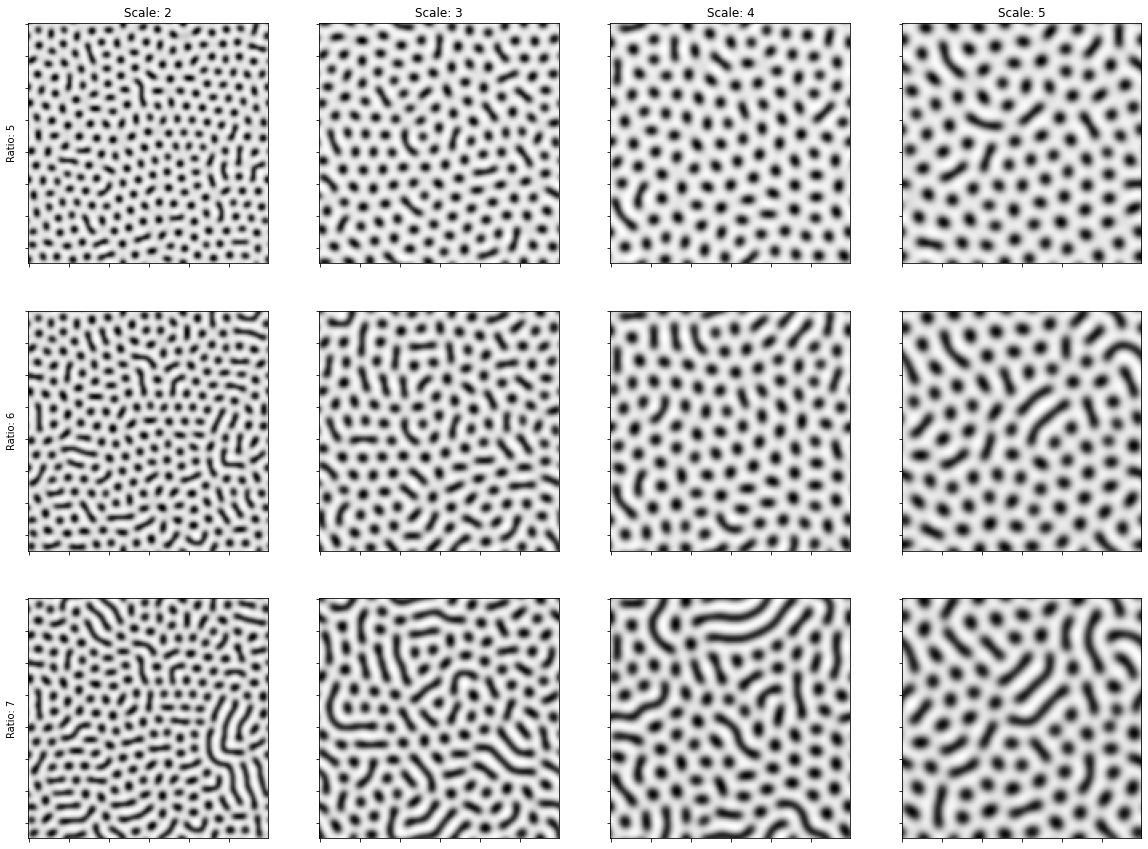

In [7]:
fig, ax = plt.subplots(3, 4, figsize = (20, 15), sharex=True, sharey=True)

for i, ratio in enumerate(range(5, 8)):
    ax[i][0].set_ylabel(f"Ratio: {ratio}")
    for j, scale in enumerate(range(2, 6)):
        ax[0][j].set_title(f"Scale: {scale}")
        ax[i][j].imshow(rd(ratio, scale)[0], cmap='gray')
        ax[i][j].set_yticklabels([])
        ax[i][j].set_xticklabels([])
    
plt.show()


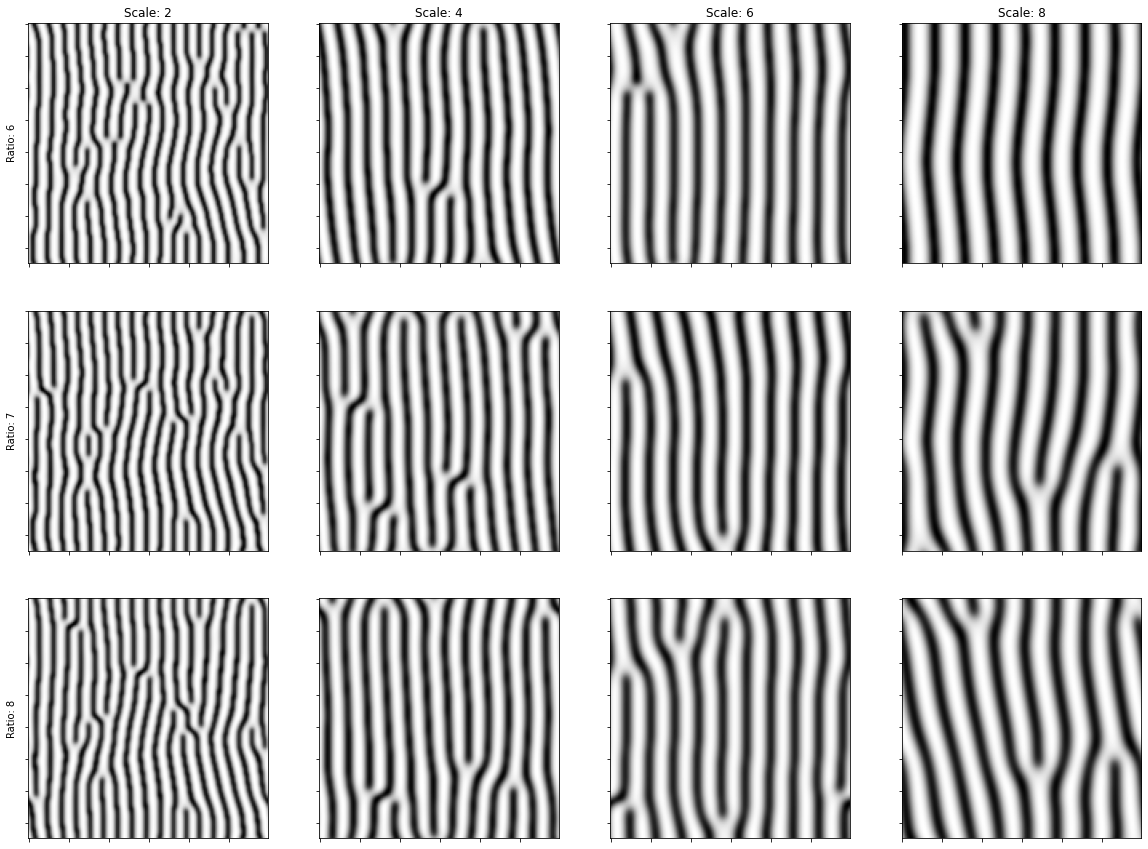

In [8]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)

for i, ratio in enumerate(range(6, 9)):
    ax[i][0].set_ylabel(f"Ratio: {ratio}")
    for j, scale in enumerate(range(2, 9, 2)):
        ax[0][j].set_title(f"Scale: {scale}")
        ax[i][j].imshow(rd(ratio, scale, speed=75, time=15000, kernel_a=kernels[0])[0], cmap='gray')
        ax[i][j].set_yticklabels([])
        ax[i][j].set_xticklabels([])

plt.show()


Wall time: 12.1 s
Wall time: 7.91 s
Wall time: 7.6 s


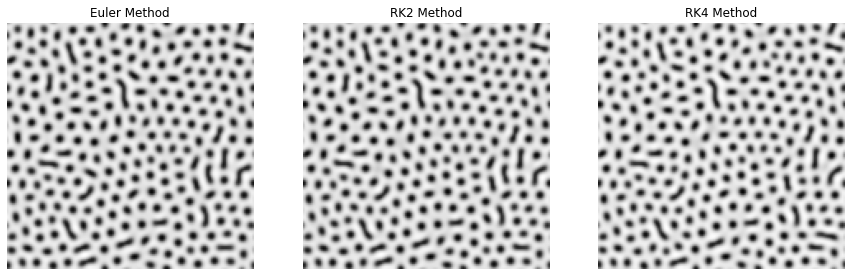

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ratio = 5
scale = 2

ax[0].set_title('Euler Method')
ax[0].axis('off')
%time ax[0].imshow(rd(ratio, scale, time=10000)[0], cmap='gray')

ax[1].set_title('RK2 Method')
ax[1].axis('off')
%time ax[1].imshow(rd(ratio, scale, time=7500, speed=150, model=RK2)[0], cmap='gray')

ax[2].set_title('RK4 Method')
ax[2].axis('off')
%time ax[2].imshow(rd(ratio, scale, time=5000, speed=250, model=RK4)[0], cmap='gray')

plt.show()
